# Driver Drowsiness Detection - CSIS 4260
### Spl. Topics in Data Analytics
#### Parth Dhamija - 300323048

#### About the Data

Drowsiness can put lives of many drivers and workers in danger. It is important to design practical and easy-to-deploy real-world systems to detect the onset of drowsiness.With the help of this code, we will address early drowsiness detection, which can provide alerts and offer ample time to react. We present a large and public real-life dataset of 60 subjects, with video segments labeled as alert, low vigilant, or drowsy. This dataset consists of around 30 hours of video, with contents ranging from subtle signs of drowsiness to more obvious ones. We also benchmark a temporal model for our dataset, which has low computational and storage demands.

To read more about the Dataset - https://sites.google.com/view/utarldd/home

Download the Dataset - http://vlm1.uta.edu/~athitsos/projects/drowsiness/

#### Data Dictionary

Subject ID: xxx <br>
Image number: xxx <br>
Gender: 0 - Male, 1 - Female <br>
Glasses:0 - No, 1 - Yes <br>
Eye State: 0 - Close, 1 - Open <br>
Reflections: 0 - None, 1 - Low, 2 - High <br>
Lighting Conditions: 0 - Bad, 1 - Good <br>
Sensor type: 01 - RealSense SR300 640x480, 02 - IDS Imaging 1280x1024, 03 - Aptina Imagin 752x480 <br>
<br>
Example:
s001_00123_0_0_0_0_0_01.png

#### Importing Libraries

In [1]:
# !pip install tensorflow
# !pip install pygame

In [2]:
import os 
import shutil
import glob
import random
import cv2
import numpy as np
import pygame
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Processing the Data

In [3]:
Raw_DIR = r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\mrlEyes_2018_01'

Since the most important attribute of the following dataset is "Eye State". Segreagting the images into the two classes "ClosedEyes" and "OpenEyes". This will create a copy of the dataset, which still carry the descriptive attributes which the file name provides.

In [4]:
for dirpath, dirname, filename in os.walk(Raw_DIR):
    for i in tqdm([f for f in filename if f.endswith('png')]):
        if i.split('_')[4]=='0':
            shutil.copy(src=dirpath+'/'+i, dst = r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train\ClosedEyes')
        
        elif i.split('_')[4]=='1':        
            shutil.copy(src=dirpath+'/'+i, dst = r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train\OpenEyes')
             

Dividing the data to train and test. We added them to different folders

In [5]:
def create_test_closed(source, destination, percent):
#     divides closed eyes images into given percent and moves from source to destination.
    path, dirs, files_closed = next(os.walk(source))
    file_count_closed = len(files_closed)
    percentage = file_count_closed * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')   

In [6]:
def create_test_open(source, destination, percent):
#     divides open eyes images into given percent and moves from source to destination.
    path, dirs, files_open = next(os.walk(source))
    file_count_open = len(files_open)
    percentage = file_count_open * percent
    to_move = random.sample(glob.glob(source + "/*.png"), int(percentage))

    for f in enumerate(to_move):
        if not os.path.exists(destination):
            os.makedirs(destination)
        shutil.move(f[1], destination)
    print(f'moved {int(percentage)} images to the destination successfully.')

In [7]:
create_test_closed(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train\ClosedEyes', 
                    r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Test\ClosedEyes', 
                    0.2)

In [1]:
create_test_open(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train\OpenEyes', 
                    r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Test\OpenEyes', 
                    0.2)

Since the data we have limits us to some sample, we will use the ImageDataGenerator library to make more pictures using different attributes.

In [11]:
train_datagen = ImageDataGenerator(rotation_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rescale=1./255,
                                validation_split=0.2)

train_data = train_datagen.flow_from_directory(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train',
                                              target_size=(80,80),batch_size=8,class_mode='categorical',
                                              subset='training')

validation_data = train_datagen.flow_from_directory(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Train',
                                              target_size=(80,80),batch_size=8,class_mode='categorical',
                                                   subset='validation')


Found 54336 images belonging to 2 classes.
Found 13583 images belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Test',
                                              target_size=(80,80),batch_size=8,class_mode='categorical')



Found 16979 images belonging to 2 classes.


For building the model. We will be using a branch of Deep Learning known as transfer learning.

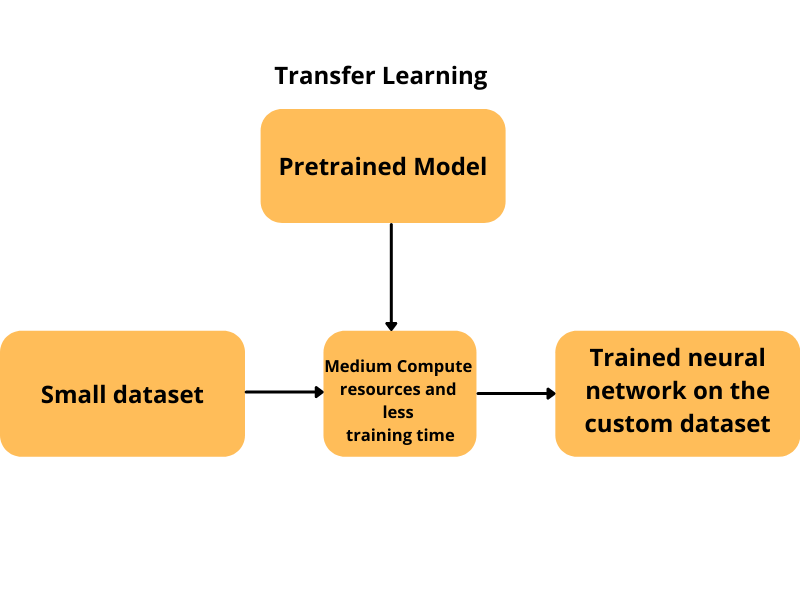

The base model being used here is - InceptionV3 {This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.)

In [13]:
bmodel = InceptionV3(include_top=False,
                    weights='imagenet',
                    input_tensor=Input(shape=(80,80,3)))

In [14]:
hmodel = bmodel.output

In [15]:
bmodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normalization[

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 7, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 7, 7, 96)     0           ['batch_normalization_10[0][0]'] 
          

                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 96)     55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 7, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 7, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 7, 7, 48)     0           ['batch_normalization_20[0][0]'] 
          

 conv2d_34 (Conv2D)             (None, 3, 3, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 3, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 3, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 3, 3, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 3, 3, 128)   384         ['conv2d_35[0][0]']              
 ormalizat

 activation_44 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 3, 3, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed4[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 3, 3, 160)   480         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_66 (Conv2D)             (None, 3, 3, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 3, 3, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 3, 3, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_61[0][0]'] 
          

                                                                                                  
 batch_normalization_74 (BatchN  (None, 3, 3, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
                                                                                                  
 conv2d_75

 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 1, 768)    0           ['activation_78[0][0]',          
          

                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activation_93 (Activation)     (None, 1, 1, 192)    0           ['batch_normalization_93[0][0]'] 
          

In [16]:
hmodel = Flatten()(hmodel)
hmodel = Dense(64,activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation='softmax')(hmodel)

model = Model(inputs=bmodel.input, outputs=hmodel)
for layer in bmodel.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normalization[0][0]']

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 7, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 7, 64)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 7, 7, 96)     0           ['batch_normalization_10[0][0]'] 
          

                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 96)     55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 7, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 7, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 7, 7, 48)     0           ['batch_normalization_20[0][0]'] 
          

 conv2d_34 (Conv2D)             (None, 3, 3, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 3, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 3, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 3, 3, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 3, 3, 128)   384         ['conv2d_35[0][0]']              
 ormalizat

 activation_44 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 3, 3, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed4[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 3, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 3, 3, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 3, 3, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 3, 3, 160)   480         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_66 (Conv2D)             (None, 3, 3, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 3, 3, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 3, 3, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_61[0][0]'] 
          

                                                                                                  
 batch_normalization_74 (BatchN  (None, 3, 3, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
                                                                                                  
 conv2d_75

 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 1, 768)    0           ['activation_78[0][0]',          
          

                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activation_93 (Activation)     (None, 1, 1, 192)    0           ['batch_normalization_93[0][0]'] 
          

In [18]:
checkpoint = ModelCheckpoint(r'C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Models\model.h5',
                            monitor='val_loss',save_best_only=True,verbose =3)

earlystop = EarlyStopping(monitor='val_loss',patience=7, verbose = 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss',patience = 3, verbose=3)

callbacks=[checkpoint,earlystop,learning_rate]

In [19]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit_generator(train_data,steps_per_epoch=train_data.samples//8,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//8,
                   callbacks=callbacks,
                   epochs=8)

C:\Users\parth\AppData\Local\Temp\ipykernel_23056\1429082508.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,steps_per_epoch=train_data.samples//8,


Epoch 1/8
6792/6792 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9189
Epoch 1: val_loss improved from inf to 0.21970, saving model to C:\Users\parth\Downloads\Fall 2022\CSIS 4260 - Special Topics in Data Analytics\CSIS 4260 - Project\Models\model.h5
6792/6792 [==============================] - 272s 39ms/step - loss: 0.2096 - accuracy: 0.9189 - val_loss: 0.2197 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 2/8
6791/6792 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9307
Epoch 2: val_loss did not improve from 0.21970
6792/6792 [==============================] - 268s 39ms/step - loss: 0.1769 - accuracy: 0.9307 - val_loss: 0.2684 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 3/8
6791/6792 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9356
Epoch 3: val_loss did not improve from 0.21970
6792/6792 [==============================] - 263s 39ms/step - loss: 0.1684 - accuracy: 0.9356 - val_loss: 0.2860 - val_accuracy: 0.8940 -

#### Model Evaluation

In [20]:
acc_tr , loss_tr = model.evaluate_generator(train_data)
print(acc_tr)
print(loss_tr)

C:\Users\parth\AppData\Local\Temp\ipykernel_23056\2876905264.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_tr , loss_tr = model.evaluate_generator(train_data)


0.1593315154314041
0.9381073117256165


In [21]:
acc_vr , loss_vr = model.evaluate_generator(validation_data)
print(acc_vr)
print(loss_vr)

C:\Users\parth\AppData\Local\Temp\ipykernel_23056\3811301195.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_vr , loss_vr = model.evaluate_generator(validation_data)


0.2297927290201187
0.9002429246902466


In [22]:
acc_test , loss_test = model.evaluate_generator(test_data)
print(acc_test)
print(loss_test)

C:\Users\parth\AppData\Local\Temp\ipykernel_23056\3161075828.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc_test , loss_test = model.evaluate_generator(test_data)


0.14624197781085968
0.9417515993118286
